In [1]:
import kagglehub
sumanthvrao_daily_climate_time_series_data_path = kagglehub.dataset_download('sumanthvrao/daily-climate-time-series-data')

print('Data source import complete.')


Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Data source import complete.


- Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install protobuf==3.20.3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


- Load Dataset

In [3]:
file_path = '/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv'

df_raw = pd.read_csv(file_path)

print(f"Data Shape: {df_raw.shape}")
print('Raw Data Preview:')
print(df_raw.head())

print('\nDataset Info:')
print(df_raw.info())

Data Shape: (1462, 5)
Raw Data Preview:
         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


- Data Preprocessing

In [4]:
df = df_raw.copy()
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')
data_target = df[['meantemp']]

print(data_target.head())

             meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000


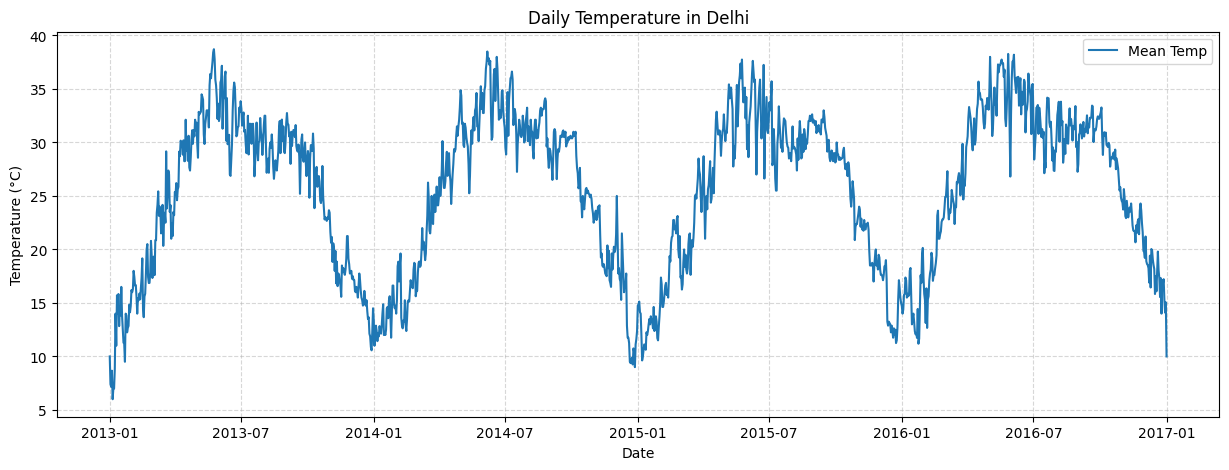

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df['meantemp'], label='Mean Temp')
plt.title('Daily Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [6]:
# Train-Test Split
train_size = int(len(data_target) * 0.8)
train_data = data_target.iloc[:train_size]
test_data = data_target.iloc[train_size:]

print(f'Training Samples: {len(train_data)}')
print(f'Testing Samples: {len(test_data)}')


Training Samples: 1169
Testing Samples: 293


In [7]:
# Scaling (Normalization)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

- Windowing (Create Sequences)
  
// Converting long series data into X and y slices

In [8]:
def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # Ambil 30 hari ke belakang sebagai Input (X)
        X.append(dataset[i : i + window_size])
        # Ambil 1 hari ke depan sebagai Target (y)
        y.append(dataset[i + window_size])
    return np.array(X), np.array(y)

# Hyperparameter: We use the last 30 days
WINDOW_SIZE = 30

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

print(f'X_train shape: {X_train.shape} (Samples, Timesteps, Features)')
print(f'y_train shape: {y_train.shape}')

X_train shape: (1139, 30, 1) (Samples, Timesteps, Features)
y_train shape: (1139, 1)


- Building LSTM Model

In [9]:
# Build RNN Architecture
model = Sequential([
    # Layer 1: LSTM
    LSTM(units=50, activation='relu', input_shape=(WINDOW_SIZE, 1)),

    # Layer 2: Output Dense
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

- Training Model

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.3496 - val_loss: 0.1754
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0497 - val_loss: 0.0083
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

- Visulalization

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


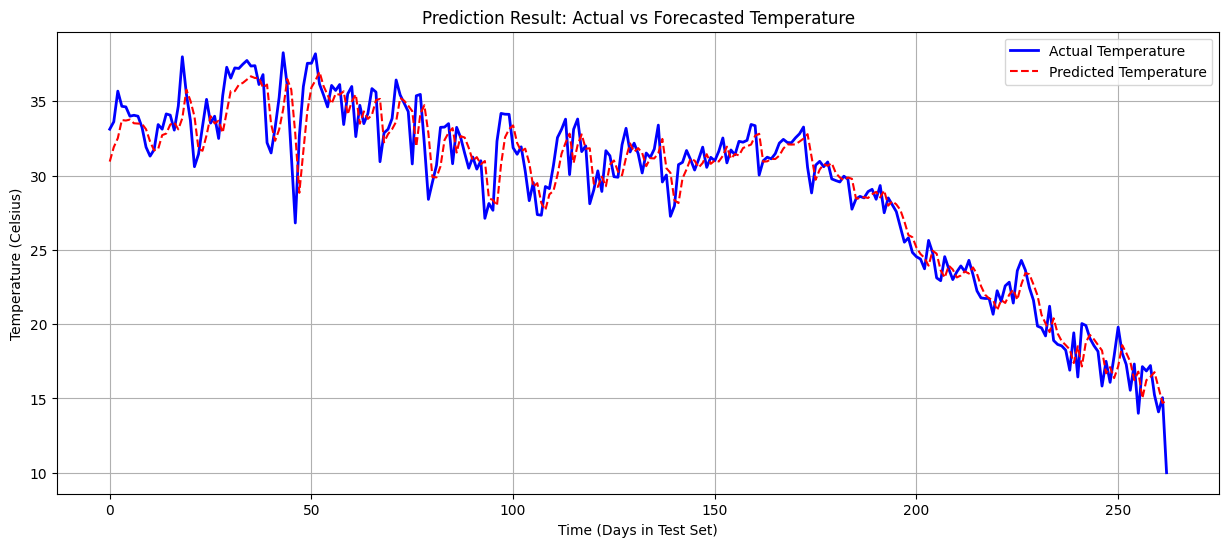

In [11]:
# 1. Predict on Test Data
predictions = model.predict(X_test)

# 2. Inverse Transform
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 3. Plotting Results
plt.figure(figsize=(15, 6))

# Real Data Plot (Testing)
plt.plot(y_test_actual, color='blue', label='Actual Temperature', linewidth=2)

# Prediction Data Plot
plt.plot(predictions_actual, color='red', label='Predicted Temperature', linestyle='--')

plt.title('Prediction Result: Actual vs Forecasted Temperature')
plt.xlabel('Time (Days in Test Set)')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

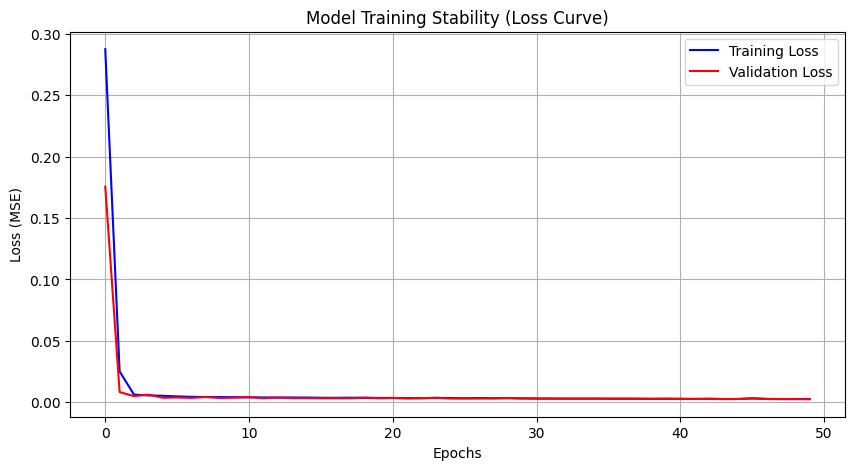

In [12]:
# Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Training Stability (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


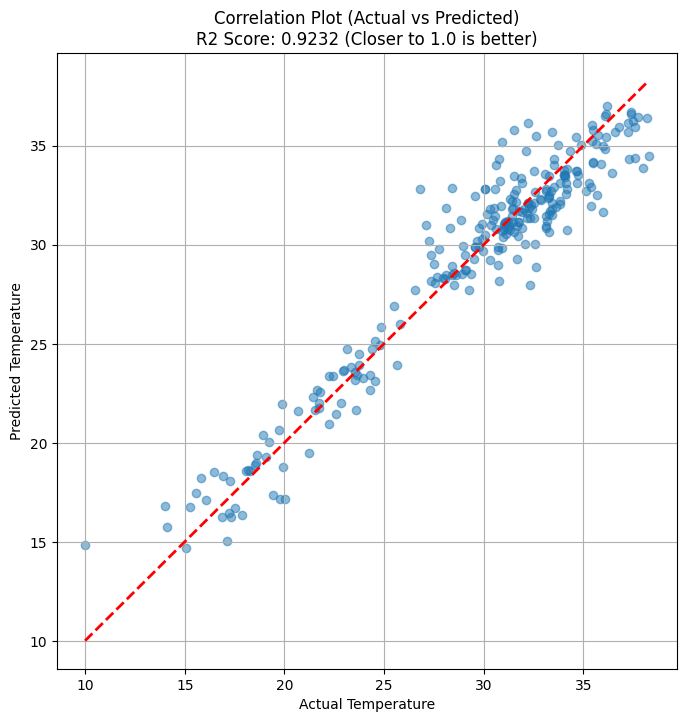

Final R2 Score: 0.9232
Mean Absolute Error: 1.2348 degrees Celsius


In [13]:
# Scatter Plot & Metrics
r2 = r2_score(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)

plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, predictions_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.title(f'Correlation Plot (Actual vs Predicted)\nR2 Score: {r2:.4f} (Closer to 1.0 is better)')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.grid(True)
plt.show()

print(f"Final R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f} degrees Celsius")

-